In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf
import numpy as np
import matplotlib.pyplot as plt
#https://www.data4v.com/tutorial-hierarchical-clustering-in-spark-with-bisecting-k-means/

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
spark = SparkSession.builder \
    .appName('bisectingK') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [4]:
data_path = "/papers_2000/kws/"

In [5]:
# Dummy table created ny AL_read_papers notebook
# Original data is first 30000 papers from 2010 with 50 assigned keywords
paps = spark.read.json("../data/processed/"+data_path+"/dummy/")

In [6]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())
# remving nans
print(papersWIDs.count())
papersWIDs_woNA = papersWIDs.dropna()
print(papersWIDs_woNA.count())
papersWIDs_woNA_woNone = papersWIDs_woNA.filter("None == 0")
print(papersWIDs_woNA_woNone.count())

7192
7141
5972


In [7]:
from pyspark.sql.functions import col, log, lit

In [8]:
def log_transform(data, column_name):
    return data.withColumn("log_"+column_name,  log(lit(1) + col(column_name)))

In [9]:
data = papersWIDs_woNA_woNone
# data = log_transform(data, "citation_count")
# data = log_transform(data, "number_of_pages")
# data = log_transform(data, "num_refs")
data = data.dropna()

Included all columns except title and ID since those are strings and identifiers

In [10]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(
    # inputCols=[c for c in data.columns if not c in ['id', 'title', 'citation_count', 'number_of_pages', 'num_refs']],
    inputCols=[c for c in data.columns if not c in ['id', 'title']],
    outputCol='features')
assembled_data=assemble.transform(data)
#assembled_data.show(2)

In [11]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
scaled_data=data_scale.transform(assembled_data)
#data_scale_output.show(2)

In [12]:
scaled_data.count()

5972

# Fit the model

In [13]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [14]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette')
print("["+("".join(["."]*len(range(2,50))))+"]")
print("[", end="")
for K in range(2,50):
    print(".", end="")
    KMeans_=KMeans(featuresCol='features', k=K)
    KMeans_fit=KMeans_.fit(scaled_data)
    KMeans_transform=KMeans_fit.transform(scaled_data) 
    evaluation_score=evaluator.evaluate(KMeans_transform)
    silhouette_scores.append(evaluation_score)
silhouette_scores_array = np.array([[k, s] for k, s in zip(range(2,50), silhouette_scores)])

[................................................]
[................................................

In [15]:
Lcost = []
print("".join(["["]+[" "]*(50-2)+["]"]))
print("[", end="")
for k in range(2, 50):
    model = KMeans(
        featuresCol='features', k=k, seed = k).fit(scaled_data)
    cost = model.summary.trainingCost
    Lcost = Lcost + [[k, cost]]
    print(".", end="")
print("]")
Lcost_array = np.array(Lcost)

[                                                ]
[................................................]


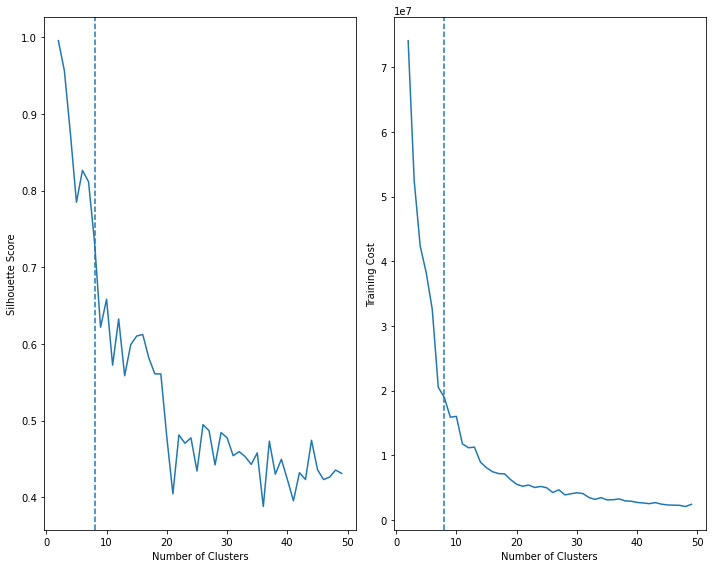

In [16]:
import matplotlib.pyplot as plt
def make_plot(data, y_label, ax, k0):
    ax.plot(data[:,0], data[:,1])
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel(y_label)
    ax.axvline(x=k0, linestyle='--')
k0 = 8
fig, ax = plt.subplots(1,2, figsize =(10,8))
make_plot(data=silhouette_scores_array, y_label='Silhouette Score', ax=ax[0], k0=k0)
make_plot(data=Lcost_array, y_label='Training Cost', ax=ax[1], k0=8)
plt.tight_layout()

The predictions seem pretty stable. With k=1  clusters' sizes and centroid positions do not depend strongly on the seed

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
k0 = 8
for seed in range(10):
    KMeans_= KMeans(featuresCol='features', k=k0, seed = seed)
    KMeans_Model=KMeans_.fit(assembled_data)
    KMeans_transform=KMeans_Model.transform(assembled_data)
    print("seed=", seed, "\t",
        list(KMeans_Model.summary.predictions.groupby("prediction").count().sort(desc("count")).toPandas()["count"]),
        "\t",
        [round(C[0],2) for C in KMeans_Model.clusterCenters()]
    )

seed= 0 	 [4186, 1332, 312, 80, 44, 15, 2, 1] 	 [0.09, 0.0, 0.07, 0.1, 0.0, 0.27, 0.12, 0.12]
seed= 1 	 [4698, 896, 168, 105, 51, 42, 10, 2] 	 [0.1, 0.0, 0.1, 0.12, 0.18, 0.26, 0.11, 0.12]
seed= 2 	 [4977, 690, 136, 101, 42, 22, 2, 2] 	 [0.1, 0.0, 0.11, 0.09, 0.11, 0.0, 0.29, 0.16]
seed= 3 	 [4167, 1348, 314, 81, 44, 15, 2, 1] 	 [0.12, 0.0, 0.12, 0.07, 0.27, 0.09, 0.0, 0.1]
seed= 4 	 [4897, 650, 261, 101, 43, 17, 2, 1] 	 [0.19, 0.0, 0.28, 0.12, 0.09, 0.0, 0.06, 0.11]
seed= 5 	 [4135, 1370, 323, 82, 44, 15, 2, 1] 	 [0.12, 0.0, 0.11, 0.0, 0.12, 0.09, 0.07, 0.27]
seed= 6 	 [4695, 986, 183, 51, 44, 10, 2, 1] 	 [0.1, 0.0, 0.12, 0.0, 0.12, 0.1, 0.12, 0.27]
seed= 7 	 [4165, 1338, 313, 78, 43, 23, 10, 2] 	 [0.09, 0.0, 0.12, 0.1, 0.12, 0.12, 0.09, 0.28]
seed= 8 	 [4185, 1323, 314, 82, 43, 20, 3, 2] 	 [0.09, 0.0, 0.1, 0.12, 0.12, 0.28, 0.0, 0.12]
seed= 9 	 [4892, 868, 134, 44, 28, 3, 2, 1] 	 [0.1, 0.0, 0.27, 0.11, 0.09, 0.0, 0.0, 0.12]


Here are mean citation counts per clusters

In [19]:
from pyspark.sql.functions import stddev, count as _count, lit

KMeans_Model = KMeans(featuresCol='features', k=k0, seed = 1).fit(assembled_data)
tab = KMeans_Model.summary.predictions.\
    groupby("prediction").agg(
        mean("citation_count").alias("mean"),
        stddev("citation_count").alias("sigma"),
        _count(lit(1)).alias("count")
    ).\
    sort(desc("mean"))
tab

prediction,mean,sigma,count
1,3838.5,337.28993462598316,2
2,1436.6,350.28407519231206,10
3,681.6274509803922,143.65123887865553,51
6,308.5952380952381,82.73427908232665,168
7,104.8203125,38.64492523164223,896
4,48.61904761904762,59.14427941522145,105
0,13.599829714772243,15.051297424292642,4698
5,12.761904761904763,41.857953479047715,42


In [20]:
tab.toPandas().to_csv("../data/processed/"+data_path+"/kmeans_mean_table.csv")

Let us do some visuals. PCA is very usefull for this

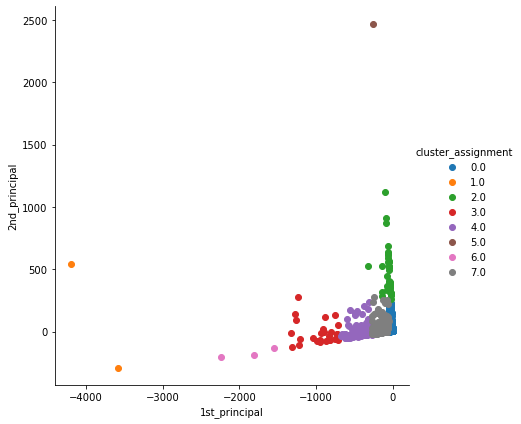

In [21]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(KMeans_transform)

import numpy as np
X_pca = pca_transformed.rdd.map(lambda row: row.pca).collect()
X_pca = np.array(X_pca)


cluster_assignment = np.array(KMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
# plt.xlim(0, 750)
# plt.ylim(-500, 1000)
plt.savefig("../data/processed/"+data_path+"/kmeans_pca.pdf")

The clustering is evident

In [22]:
np.savetxt("../data/processed/"+data_path+"/kmeans_silhouette_scores_array.txt", silhouette_scores_array)
np.savetxt("../data/processed/"+data_path+"/kmeans_Lcost.txt", Lcost_array)

KMeans_transform.write.mode("overwrite").json("../data/processed/"+data_path+"/KMeans/")